In [1]:
from utils.model_definitions import BinaryDNN_classical
import torch
from utils.imports import *
from utils.Preprocessing import *
from utils.Helper import *
device = "cuda" if torch.cuda.is_available() else "cpu"
DNN = BinaryDNN_classical().to(device)
# load_path = "models/Binary_DNN_" # Path to load model
load_path = "checkpoints/Binary_DNN_FULLENT_AUC.6993.1011_0915.pt"
# load_path = "models/DNN_model_best_valLoss.pt"

# Load the checkpoint
checkpoint = torch.load(load_path)

# Restore model weights
DNN.load_state_dict(checkpoint["DNN_state_dict"])
    
print(f"Loaded model from {load_path}")

Loaded model from checkpoints/Binary_DNN_FULLENT_AUC.6993.1011_0915.pt


In [2]:
import pandas as pd
from utils.Preprocessing import Preprocess, ClassificationDataset, DataLoader
TRAIN_FILE = '../Data/2025-Quantathon-Tornado-Q-training_data-640-examples.xlsx'
TEST_FILE = '../Data/2025-Quantum-Tornado-Q-test_data-200-examples.xlsx'
VALIDATION_FILE = '../Data/2025-Quantum-Tornado-validation_data-160-examples.xlsx'

# Load training data
df_train = pd.read_excel(TRAIN_FILE)
# Load test data
df_test = pd.read_excel(TEST_FILE)
# Load validation data
df_val = pd.read_excel(VALIDATION_FILE)

# Define variable and dataset
batch_size = 64
lr = 1e-2

X_train, y_train, X_test, y_test, X_val, y_val = Preprocess(df_train, df_test, df_val, balance = 'smote', classes = 'binary')

print(y_test[:])
print(y_train[:])
print(y_val[:])

train_data = ClassificationDataset(X_train, y_train)
validation_data = ClassificationDataset(X_val, y_val)
test_data = ClassificationDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(validation_data, batch_size=64, shuffle=False, drop_last=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, drop_last=True)

X_batch, y_batch = next(iter(train_loader))

0      0
1      0
2      0
3      0
4      1
      ..
195    0
196    0
197    1
198    0
199    0
Name: ef_binary, Length: 200, dtype: int64
0       0
1       0
2       0
3       0
4       0
       ..
1137    1
1138    1
1139    1
1140    1
1141    1
Name: ef_binary, Length: 1142, dtype: int64
0      0
1      0
2      1
3      0
4      0
      ..
155    0
156    0
157    0
158    0
159    0
Name: ef_binary, Length: 160, dtype: int64


(192,) (192,) (192,)
[0 1]
AUC: 0.6404, F1: 0.2222, Accuracy: 0.7812, CSI: 0.1250


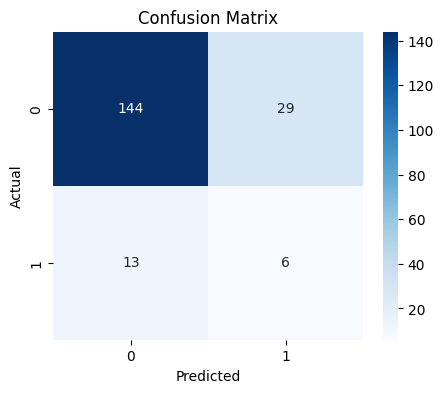

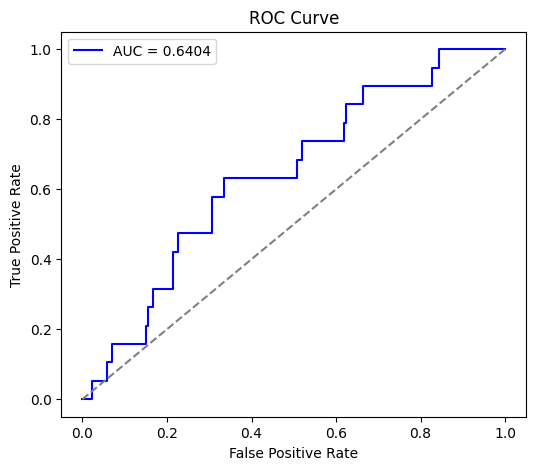

In [3]:
# --- Set model to evaluation mode ---
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from utils.Helper import plot_confusion_matrix
DNN.eval()

all_targets = []
all_preds = []
all_outputs = []

with torch.no_grad():
    for features, target in test_loader:
        features = features.to(device)
        target = target.to(device).float().unsqueeze(-1)

        outputs = DNN(features)
        preds = (outputs > 0.5).float()

        all_targets.append(target.cpu())
        all_preds.append(preds.cpu())
        all_outputs.append(outputs.cpu())

# --- Concatenate all batches ---
all_targets = torch.cat(all_targets).squeeze().long().numpy()  # integers 0/1
all_preds = torch.cat(all_preds).squeeze().long().numpy()
all_outputs = torch.cat(all_outputs).squeeze().numpy()             # floats in [0,1]

# --- Sanity check ---
print(all_targets.shape, all_preds.shape, all_outputs.shape)
print(np.unique(all_targets))  # should be [0,1]

# --- Compute Metrics ---
cm = confusion_matrix(all_targets, all_preds)
auc_score = roc_auc_score(all_targets, all_outputs)  # should work now
f1 = f1_score(all_targets, all_preds)
acc = accuracy_score(all_targets, all_preds)

# Critical Success Index (CSI)
tp = cm[1,1]
fn = cm[1,0]
fp = cm[0,1]
csi = tp / (tp + fn + fp)

print(f"AUC: {auc_score:.4f}, F1: {f1:.4f}, Accuracy: {acc:.4f}, CSI: {csi:.4f}")

# --- Plot Confusion Matrix ---
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# --- Plot ROC Curve ---
fpr, tpr, thresholds = roc_curve(all_targets, all_outputs)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}', color='blue')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()



In [4]:
# Load training data
df_train = pd.read_excel(TRAIN_FILE)
# Load test data
df_test = pd.read_excel(TEST_FILE)
# Load validation data
df_val = pd.read_excel(VALIDATION_FILE)



X_train, y_train, X_test, y_test, X_val, y_val = Preprocess(df_train, df_test, df_val, balance = 'smote', classes = 'multiclass')

train_data = ClassificationDataset(X_train, y_train)
validation_data = ClassificationDataset(X_val, y_val)
test_data = ClassificationDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(validation_data, batch_size=64, shuffle=False, drop_last=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, drop_last=True)

X_batch, y_batch = next(iter(train_loader))


AUC: 0.5543, F1: 0.3449, Accuracy: 0.5365
Class 0 CSI: 0.5299
Class 1 CSI: 0.2796
Class 2 CSI: 0.1429
Class 3 CSI: 0.0000


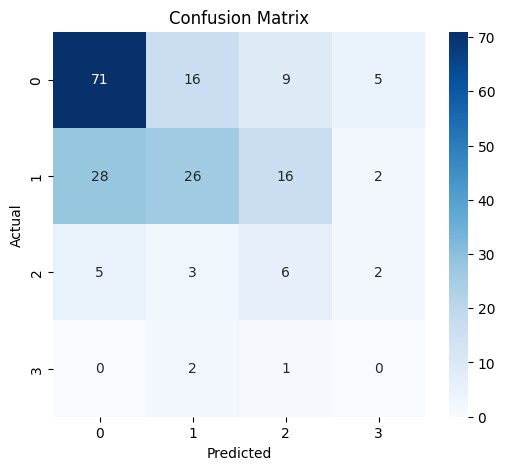

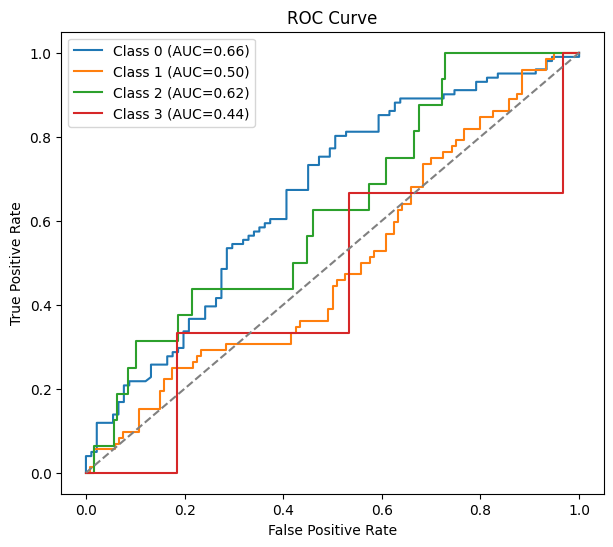

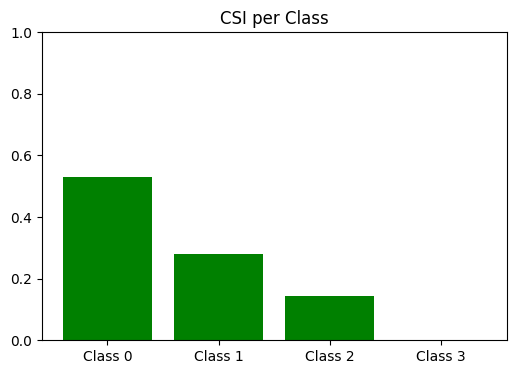

In [5]:
from utils.model_definitions import MultiClassDNN_classical

DNN = MultiClassDNN_classical().to(device)

load_path = "checkpoints/Multiclass_DNN_3Layer_AUC.8.1011_1012.pt"

# Load the checkpoint
checkpoint = torch.load(load_path)

# Restore model weights
DNN.load_state_dict(checkpoint["DNN_state_dict"])

DNN.eval()
all_targets, all_preds, all_probs = [], [], []

with torch.no_grad():
    for features, target in test_loader:
        features = features.to(device)
        target = target.to(device).long()
        outputs = DNN(features)
        
        if outputs.shape[1] == 1:
            # Binary case
            probs = torch.sigmoid(outputs).squeeze(-1)
            preds = (probs > 0.5).long()
        else:
            # Multiclass case
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

        all_targets.append(target.cpu())
        all_preds.append(preds.cpu())
        all_probs.append(probs.cpu())

# Concatenate
all_targets = torch.cat(all_targets).numpy()
all_preds = torch.cat(all_preds).numpy()
all_probs = torch.cat(all_probs).numpy()

# Metrics
cm = confusion_matrix(all_targets, all_preds)
acc = accuracy_score(all_targets, all_preds)
if outputs.shape[1] == 1:
    f1 = f1_score(all_targets, all_preds)
    auc_score = roc_auc_score(all_targets, all_probs)
    csi = cm[1,1] / (cm[1,1] + cm[1,0] + cm[0,1])
else:
    num_classes = outputs.shape[1]
    f1 = f1_score(all_targets, all_preds, average='macro')
    auc_score = roc_auc_score(np.eye(num_classes)[all_targets], all_probs, multi_class='ovr')
    csi = []
    for i in range(num_classes):
        tp = cm[i,i]
        fn = cm[i,:].sum() - tp
        fp = cm[:,i].sum() - tp
        csi.append(tp / (tp + fn + fp) if (tp+fn+fp)>0 else 0)

# Print metrics
print(f"AUC: {auc_score:.4f}, F1: {f1:.4f}, Accuracy: {acc:.4f}")
if outputs.shape[1] > 1:
    for i, c in enumerate(csi):
        print(f"Class {i} CSI: {c:.4f}")
else:
    print(f"CSI: {csi:.4f}")

# Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC curve
plt.figure(figsize=(7,6))
if outputs.shape[1] == 1:
    fpr, tpr, _ = roc_curve(all_targets, all_probs)
    plt.plot(fpr, tpr, label=f'AUC={auc_score:.4f}')
else:
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve((all_targets==i).astype(int), all_probs[:,i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC={roc_auc:.2f})')
plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# CSI bar for multiclass
if outputs.shape[1] > 1:
    plt.figure(figsize=(6,4))
    plt.bar([f'Class {i}' for i in range(num_classes)], csi, color='green')
    plt.ylim(0,1)
    plt.title('CSI per Class')
    plt.show()


In [6]:
TRAIN_FILE = '../Data/2025-Quantathon-Tornado-Q-training_data-640-examples.xlsx'
TEST_FILE = '../Data/2025-Quantum-Tornado-Q-test_data-200-examples.xlsx'
VALIDATION_FILE = '../Data/2025-Quantum-Tornado-validation_data-160-examples.xlsx'

# Load training data
df_train = pd.read_excel(TRAIN_FILE)
# Load test data
df_test = pd.read_excel(TEST_FILE)
# Load validation data
df_val = pd.read_excel(VALIDATION_FILE)

# Quantum augmented datasets using random shadows
EXTRA_TRAIN = "../Data/36_featuresXY_train_QuantumLayers3.csv"
EXTRA_TEST  = "../Data/36_featuresXY_test_QuantumLayers3.csv"
EXTRA_VALID = "../Data/36_featuresXY_val_QuantumLayers3.csv"

# Extra features
extra_train_df = pd.read_csv(EXTRA_TRAIN)
extra_test_df = pd.read_csv(EXTRA_TEST)
extra_valid_df = pd.read_csv(EXTRA_VALID)

# Drop first column by index
extra_train_df = extra_train_df.drop(extra_train_df.columns[0], axis=1)
extra_test_df = extra_test_df.drop(extra_test_df.columns[0], axis=1)
extra_valid_df = extra_valid_df.drop(extra_valid_df.columns[0], axis=1)

# Concatenate extra features (axis=1 for columns)
df_train = pd.concat([df_train, extra_train_df], axis=1)
df_test  = pd.concat([df_test, extra_test_df], axis=1)
df_val  = pd.concat([df_val, extra_valid_df], axis=1)

In [7]:
X_train, y_train, X_test, y_test, X_val, y_val = Preprocess(df_train, df_test, df_val, balance = 'smote', classes = 'binary')

train_data = ClassificationDataset(X_train, y_train)
validation_data = ClassificationDataset(X_val, y_val)
test_data = ClassificationDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(validation_data, batch_size=64, shuffle=False, drop_last=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, drop_last=True)

X_batch, y_batch = next(iter(train_loader))

In [8]:
from utils.model_definitions import BinaryDNN_Hybrid
DNN = BinaryDNN_Hybrid().to(device)

load_path = "checkpoints/Binary_DNN_FULLENT_AUC.6993.1011_1042.pt"

# Load the checkpoint
checkpoint = torch.load(load_path)

# Restore model weights
DNN.load_state_dict(checkpoint["DNN_state_dict"])


<All keys matched successfully>

(192,) (192,) (192,)
[0 1]
AUC: 0.5914, F1: 0.0000, Accuracy: 0.8906, CSI: 0.0000


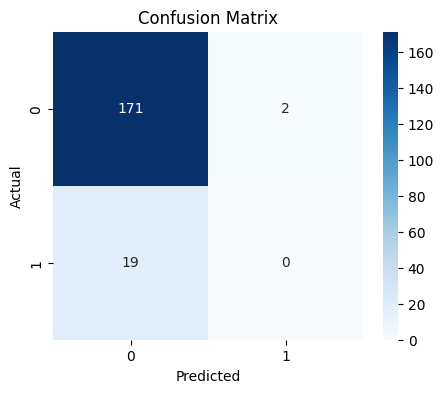

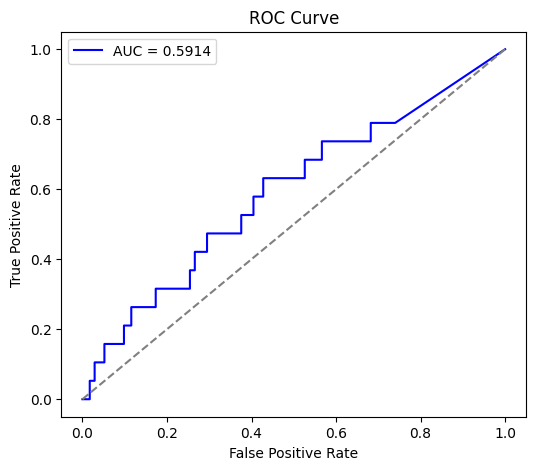

In [9]:
# --- Set model to evaluation mode ---
DNN.eval()

all_targets = []
all_preds = []
all_outputs = []

with torch.no_grad():
    for features, target in test_loader:
        features = features.to(device)
        target = target.to(device).float().unsqueeze(-1)

        outputs = DNN(features)
        preds = (outputs > 0.5).float()

        all_targets.append(target.cpu())
        all_preds.append(preds.cpu())
        all_outputs.append(outputs.cpu())

# --- Concatenate all batches ---
all_targets = torch.cat(all_targets).squeeze().long().numpy()  # integers 0/1
all_preds = torch.cat(all_preds).squeeze().long().numpy()
all_outputs = torch.cat(all_outputs).squeeze().numpy()             # floats in [0,1]

# --- Sanity check ---
print(all_targets.shape, all_preds.shape, all_outputs.shape)
print(np.unique(all_targets))  # should be [0,1]

# --- Compute Metrics ---
cm = confusion_matrix(all_targets, all_preds)
auc_score = roc_auc_score(all_targets, all_outputs)  # should work now
f1 = f1_score(all_targets, all_preds)
acc = accuracy_score(all_targets, all_preds)

# Critical Success Index (CSI)
tp = cm[1,1]
fn = cm[1,0]
fp = cm[0,1]
csi = tp / (tp + fn + fp)

print(f"AUC: {auc_score:.4f}, F1: {f1:.4f}, Accuracy: {acc:.4f}, CSI: {csi:.4f}")

# --- Plot Confusion Matrix ---
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# --- Plot ROC Curve ---
fpr, tpr, thresholds = roc_curve(all_targets, all_outputs)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}', color='blue')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [10]:
# Data paths
TRAIN_FILE = '../Data/2025-Quantathon-Tornado-Q-training_data-640-examples.xlsx'
TEST_FILE = '../Data/2025-Quantum-Tornado-Q-test_data-200-examples.xlsx'
VALIDATION_FILE = '../Data/2025-Quantum-Tornado-validation_data-160-examples.xlsx'

# Load training data
df_train = pd.read_excel(TRAIN_FILE)
# Load test data
df_test = pd.read_excel(TEST_FILE)
# Load validation data
df_val = pd.read_excel(VALIDATION_FILE)

if True:
    # Quantum augmented datasets using random shadows
    EXTRA_TRAIN = "../Data/36_featuresXY_train_QuantumLayers3.csv"
    EXTRA_TEST  = "../Data/36_featuresXY_test_QuantumLayers3.csv"
    EXTRA_VALID = "../Data/36_featuresXY_val_QuantumLayers3.csv"
    
    # Extra features
    extra_train_df = pd.read_csv(EXTRA_TRAIN)
    extra_test_df = pd.read_csv(EXTRA_TEST)
    extra_valid_df = pd.read_csv(EXTRA_VALID)
    
    # Drop first column by index
    extra_train_df = extra_train_df.drop(extra_train_df.columns[0], axis=1)
    extra_test_df = extra_test_df.drop(extra_test_df.columns[0], axis=1)
    extra_valid_df = extra_valid_df.drop(extra_valid_df.columns[0], axis=1)
    
    # Concatenate extra features (axis=1 for columns)
    df_train = pd.concat([df_train, extra_train_df], axis=1)
    df_test  = pd.concat([df_test, extra_test_df], axis=1)
    df_val  = pd.concat([df_val, extra_valid_df], axis=1)

In [11]:
from utils.model_definitions import MulticlassDNN_Hybrid

DNN = MulticlassDNN_Hybrid().to(device)


load_path = "checkpoints/Multiclass_DNN_3Layer_AUC.8.best_1011_1053.pt"


# Load the checkpoint
checkpoint = torch.load(load_path)

# Restore model weights
DNN.load_state_dict(checkpoint["DNN_state_dict"])
    
print(f"Loaded model from {load_path}")


X_train, y_train, X_test, y_test, X_val, y_val = Preprocess(df_train, df_test, df_val, balance = 'smote', classes = 'multiclass')

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

print(y_test[:])
print(y_train[:])
print(y_val[:])

train_data = ClassificationDataset(X_train, y_train)
validation_data = ClassificationDataset(X_val, y_val)
test_data = ClassificationDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(validation_data, batch_size=64, shuffle=False, drop_last=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, drop_last=True)

X_batch, y_batch = next(iter(train_loader))




Loaded model from checkpoints/Multiclass_DNN_3Layer_AUC.8.best_1011_1053.pt
(1328, 43) (1328,)
(160, 43) (160,)
(200, 43) (200,)
0      1
1      0
2      1
3      0
4      2
      ..
195    1
196    1
197    3
198    0
199    0
Name: ef_class, Length: 200, dtype: int64
0       1
1       0
2       1
3       0
4       1
       ..
1323    3
1324    3
1325    3
1326    3
1327    3
Name: ef_class, Length: 1328, dtype: int64
0      0
1      1
2      2
3      0
4      0
      ..
155    0
156    1
157    0
158    0
159    1
Name: ef_class, Length: 160, dtype: int64


AUC: 0.6258, F1: 0.2816, Accuracy: 0.5573
Class 0 CSI: 0.4967
Class 1 CSI: 0.3010
Class 2 CSI: 0.0000
Class 3 CSI: 0.0000


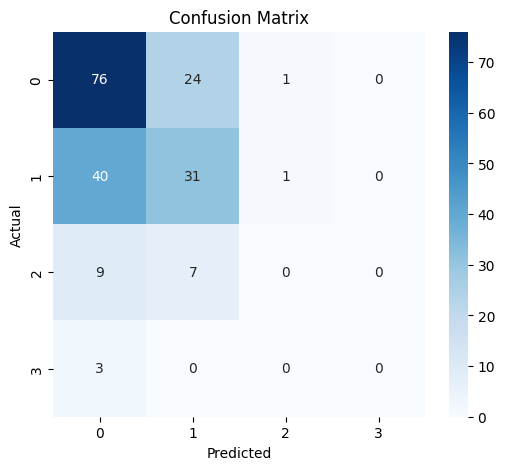

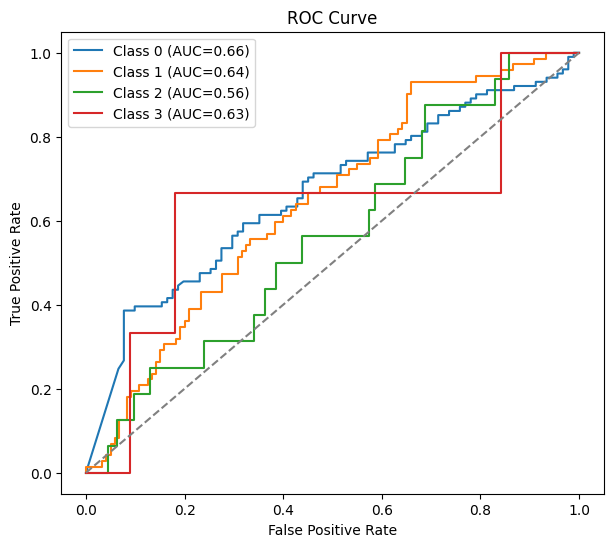

In [12]:
all_targets, all_preds, all_probs = [], [], []

with torch.no_grad():
    for features, target in test_loader:
        features = features.to(device)
        target = target.to(device).long()
        outputs = DNN(features)
        
        if outputs.shape[1] == 1:
            # Binary case
            probs = torch.sigmoid(outputs).squeeze(-1)
            preds = (probs > 0.5).long()
        else:
            # Multiclass case
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

        all_targets.append(target.cpu())
        all_preds.append(preds.cpu())
        all_probs.append(probs.cpu())

# Concatenate
all_targets = torch.cat(all_targets).numpy()
all_preds = torch.cat(all_preds).numpy()
all_probs = torch.cat(all_probs).numpy()

# Metrics
cm = confusion_matrix(all_targets, all_preds)
acc = accuracy_score(all_targets, all_preds)
if outputs.shape[1] == 1:
    f1 = f1_score(all_targets, all_preds)
    auc_score = roc_auc_score(all_targets, all_probs)
    csi = cm[1,1] / (cm[1,1] + cm[1,0] + cm[0,1])
else:
    num_classes = outputs.shape[1]
    f1 = f1_score(all_targets, all_preds, average='macro')
    auc_score = roc_auc_score(np.eye(num_classes)[all_targets], all_probs, multi_class='ovr')
    csi = []
    for i in range(num_classes):
        tp = cm[i,i]
        fn = cm[i,:].sum() - tp
        fp = cm[:,i].sum() - tp
        csi.append(tp / (tp + fn + fp) if (tp+fn+fp)>0 else 0)

# Print metrics
print(f"AUC: {auc_score:.4f}, F1: {f1:.4f}, Accuracy: {acc:.4f}")
if outputs.shape[1] > 1:
    for i, c in enumerate(csi):
        print(f"Class {i} CSI: {c:.4f}")
else:
    print(f"CSI: {csi:.4f}")

# Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC curve
plt.figure(figsize=(7,6))
if outputs.shape[1] == 1:
    fpr, tpr, _ = roc_curve(all_targets, all_probs)
    plt.plot(fpr, tpr, label=f'AUC={auc_score:.4f}')
else:
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve((all_targets==i).astype(int), all_probs[:,i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC={roc_auc:.2f})')
plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Single state shape: torch.Size([256])
Batch output shape: torch.Size([16, 256])


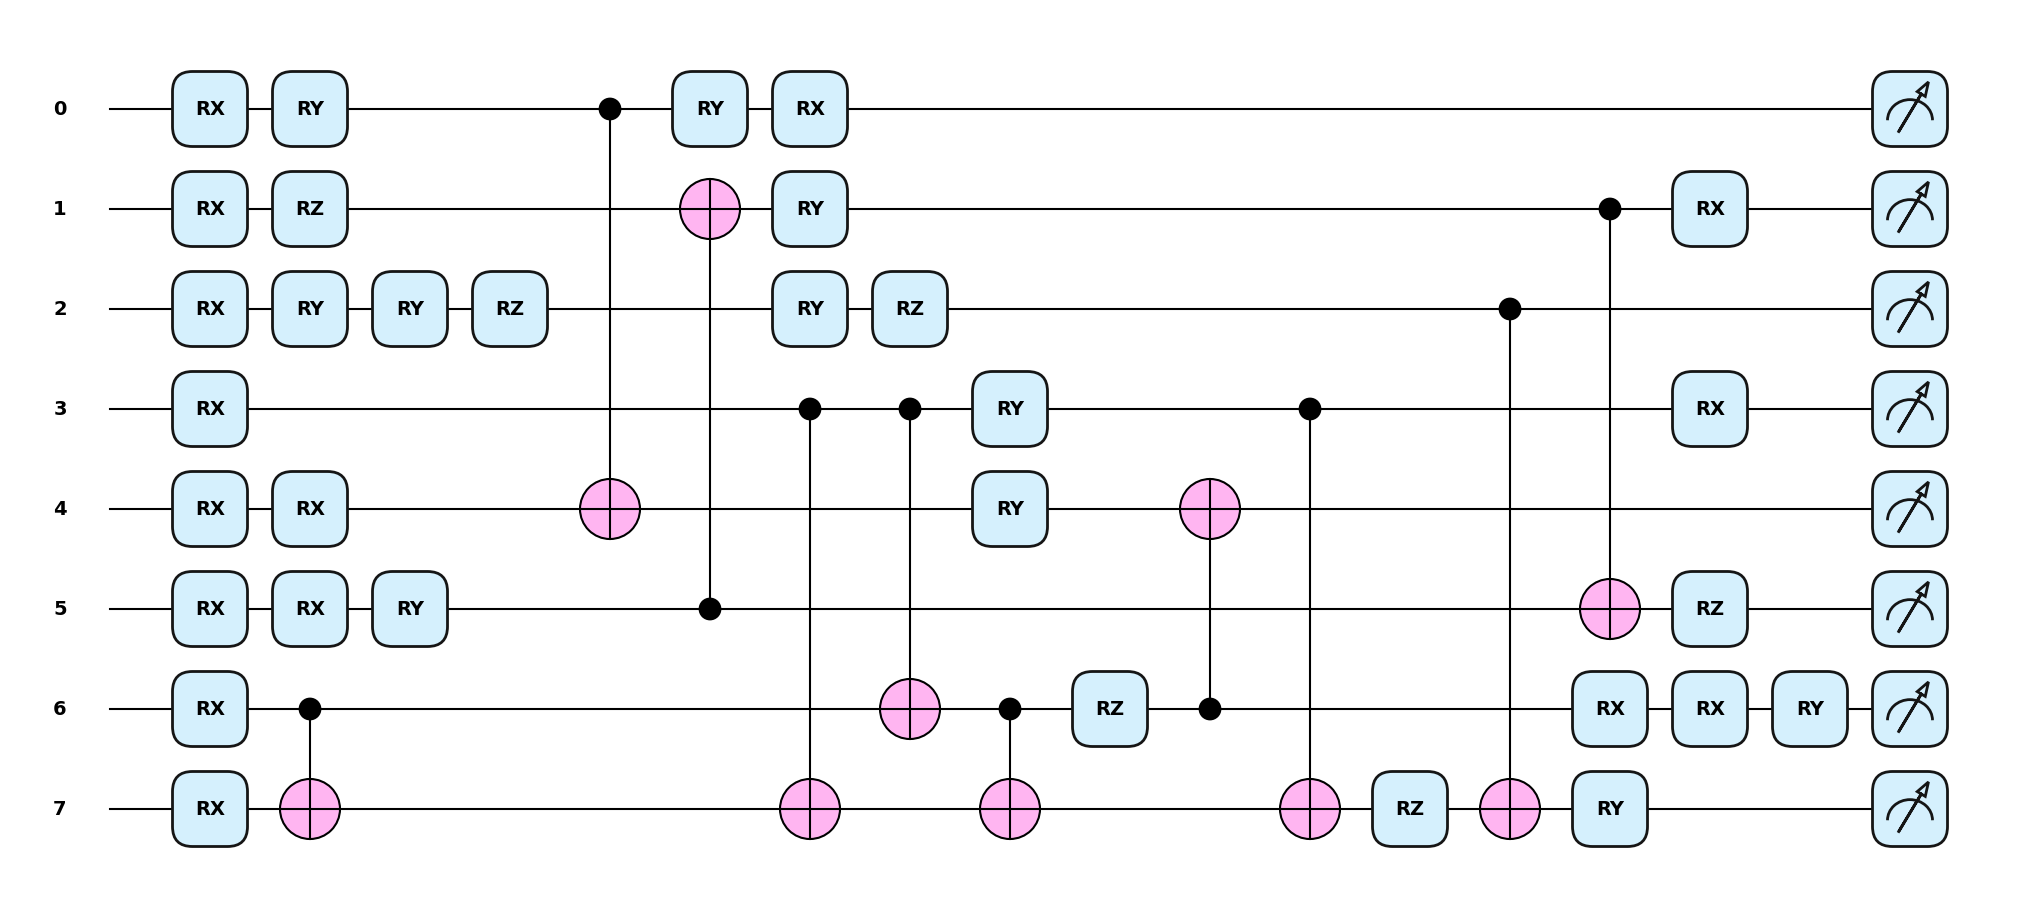

In [13]:
# Load dataset and device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data paths
TRAIN_FILE = '../Data/2025-Quantathon-Tornado-Q-training_data-640-examples.xlsx'
TEST_FILE = '../Data/2025-Quantum-Tornado-Q-test_data-200-examples.xlsx'
VALIDATION_FILE = '../Data/2025-Quantum-Tornado-validation_data-160-examples.xlsx'

# Load training data
df_train = pd.read_excel(TRAIN_FILE)
# Load test data
df_test = pd.read_excel(TEST_FILE)
# Load validation data
df_val = pd.read_excel(VALIDATION_FILE)

# Quantum device and parameters
n_qubits = 8
n_layers = 1
dev = qml.device("default.qubit", wires=n_qubits)

# Using Random Layers PQC
USE_RANDOM = True

if USE_RANDOM:
    # RandomLayers expects shape (n_layers, n_rotations_per_layer)
    # For 8 qubits, each layer typically has 3 * 8 = 24 rotations
    rand_params = np.random.uniform(0, 2 * np.pi, (n_layers, n_qubits * 3))

    @qml.qnode(dev, interface="torch", diff_method="backprop")
    def quantum_feature_embedding(f, phi):
        qml.AngleEmbedding(features=f, wires=range(n_qubits))
        RandomLayers(phi, wires=range(n_qubits), seed=6)
        return qml.state()  # returns 2**n_qubits = 256-dim statevector

# Using Strongly Entangling Layers
else:
    # StronglyEntanglingLayers expects shape (n_layers, n_wires, 3)
    rand_params = np.random.uniform(0, 2 * np.pi, (n_layers, n_qubits, 3))

    @qml.qnode(dev, interface="torch", diff_method="backprop")
    def quantum_feature_embedding(f, phi):
        qml.AngleEmbedding(features=f, wires=range(n_qubits))
        qml.StronglyEntanglingLayers(weights=phi, wires=range(n_qubits))
        return qml.state()

# Batched embedding helper
def quantum_feature_embedding_batch(x_batch, phi, device="cuda"):
    """Apply QNode to batch of inputs -> (B, 256)"""
    outputs = []
    phi = phi.detach().cpu()
    for x in x_batch:
        result = quantum_feature_embedding(x.detach().cpu(), phi)
        outputs.append(result.real.to(device))
    return torch.stack(outputs)

# Test single example
state = quantum_feature_embedding(
    torch.tensor([1/4] * n_qubits, dtype=torch.float32),
    torch.tensor(rand_params, dtype=torch.float32)
)
print("Single state shape:", state.shape)  # (256,)

# Test batch
sample = torch.randn(16, n_qubits)
phi_tensor = torch.tensor(rand_params, dtype=torch.float32)
output = quantum_feature_embedding_batch(sample, phi_tensor, device = device)
print("Batch output shape:", output.shape)  # (16, 256)

# Torch module for integration
class QuantumFeatureEmbeddingBatch(nn.Module):
    def __init__(self, device="cuda"):
        super().__init__()
        self.device = device
        self.phi = nn.Parameter(torch.tensor(
            np.random.uniform(0, 2 * np.pi, (n_layers, n_qubits * 3)), 
            dtype=torch.float32
        ))

    def forward(self, x_batch):
        outputs = []
        phi = self.phi.detach().cpu()
        for x in x_batch:
            result = quantum_feature_embedding(x.detach().cpu(), phi)
            outputs.append(result.real.to(self.device))
        return torch.stack(outputs)

# Visualize
qml.drawer.use_style('pennylane')
fig, ax = qml.draw_mpl(quantum_feature_embedding, level="device")(f=[1/4]*n_qubits, phi=rand_params)
fig.show()
plt.savefig('vlad.png')

In [ ]:

# Binary DN with Quantum Random Layer feature encoder
class BinaryPQC(nn.Module):
    def __init__(self):
        super().__init__()

        # Encodes features from dataset
        self.feature_encoder = QuantumFeatureEmbeddingBatch()

        # Classifies based on encoded features
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, features):
        feats_encoded = self.feature_encoder(features)
        class_probs = self.classifier(feats_encoded.float())

        return class_probs  # Shape: (batch_size, 1)
    
DNN = BinaryPQC().to(device)
    
load_path = "checkpoints/DNN_model_best_accuracy.pt" # Path to load model

# Load the checkpoint
checkpoint = torch.load(load_path, map_location=device)

# Restore model weights
DNN.load_state_dict(checkpoint["DNN_state_dict"])
    
print(f"Loaded model from {load_path}")
    


    
X_train, y_train, X_test, y_test, X_val, y_val = Preprocess(df_train, df_test, df_val, balance = 'smote', classes = 'binary')


train_data = ClassificationDataset(X_train, y_train)
validation_data = ClassificationDataset(X_val, y_val)
test_data = ClassificationDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(validation_data, batch_size=64, shuffle=False, drop_last=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, drop_last=True)

X_batch, y_batch = next(iter(train_loader))

Loaded model from checkpoints/DNN_model_best_accuracy.pt


In [ ]:
# --- Set model to evaluation mode ---
DNN.eval()

all_targets = []
all_preds = []
all_outputs = []

with torch.no_grad():
    for features, target in test_loader:
        features = features.to(device)
        target = target.to(device).float().unsqueeze(-1)

        outputs = DNN(features)
        preds = (outputs > 0.5).float()

        all_targets.append(target.cpu())
        all_preds.append(preds.cpu())
        all_outputs.append(outputs.cpu())

# --- Concatenate all batches ---
all_targets = torch.cat(all_targets).squeeze().long().numpy()  # integers 0/1
all_preds = torch.cat(all_preds).squeeze().long().numpy()
all_outputs = torch.cat(all_outputs).squeeze().numpy()             # floats in [0,1]

# --- Sanity check ---
print(all_targets.shape, all_preds.shape, all_outputs.shape)
print(np.unique(all_targets))  # should be [0,1]

# --- Compute Metrics ---
cm = confusion_matrix(all_targets, all_preds)
auc_score = roc_auc_score(all_targets, all_outputs)  # should work now
f1 = f1_score(all_targets, all_preds)
acc = accuracy_score(all_targets, all_preds)

# Critical Success Index (CSI)
tp = cm[1,1]
fn = cm[1,0]
fp = cm[0,1]
csi = tp / (tp + fn + fp)

print(f"AUC: {auc_score:.4f}, F1: {f1:.4f}, Accuracy: {acc:.4f}, CSI: {csi:.4f}")

# --- Plot Confusion Matrix ---
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

Single state shape: torch.Size([256])
Batch output shape: torch.Size([16, 256])


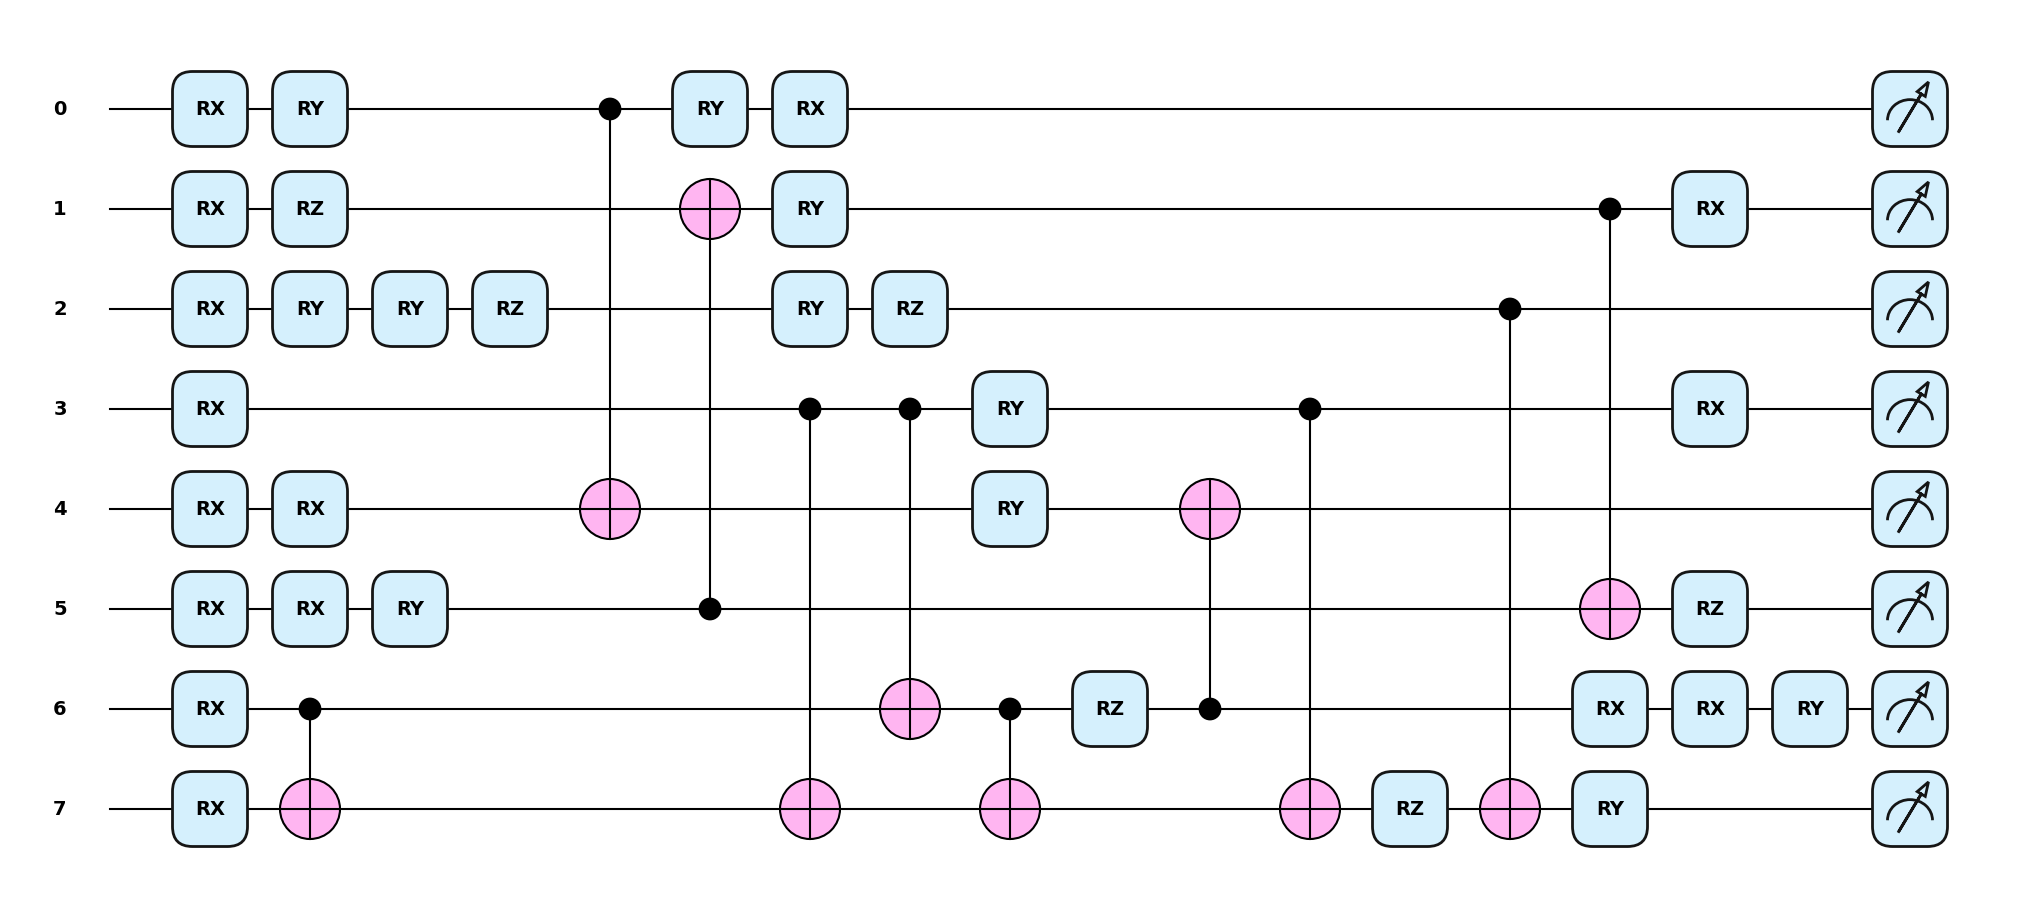

In [21]:
# Data paths
TRAIN_FILE = '../Data/2025-Quantathon-Tornado-Q-training_data-640-examples.xlsx'
TEST_FILE = '../Data/2025-Quantum-Tornado-Q-test_data-200-examples.xlsx'
VALIDATION_FILE = '../Data/2025-Quantum-Tornado-validation_data-160-examples.xlsx'

# Load training data
df_train = pd.read_excel(TRAIN_FILE)
# Load test data
df_test = pd.read_excel(TEST_FILE)
# Load validation data
df_val = pd.read_excel(VALIDATION_FILE)

# Quantum device and parameters
n_qubits = 8
n_layers = 1
dev = qml.device("default.qubit", wires=n_qubits)

# Using Random Layers PQC
USE_RANDOM = True

if USE_RANDOM:
    # RandomLayers expects shape (n_layers, n_rotations_per_layer)
    # For 8 qubits, each layer typically has 3 * 8 = 24 rotations
    rand_params = np.random.uniform(0, 2 * np.pi, (n_layers, n_qubits * 3))
    n_qubits = 8
    n_layers = 1
    phi = nn.Parameter(torch.randn(n_layers, n_qubits, 9))

    @qml.qnode(dev, interface="torch", diff_method="backprop")
    def quantum_feature_embedding(f, phi):
        qml.AngleEmbedding(features=f, wires=range(n_qubits))
        RandomLayers(phi, wires=range(n_qubits), seed=6)
        return qml.state()  # returns 2**n_qubits = 256-dim statevector

# Using Strongly Entangling Layers
else:
    # StronglyEntanglingLayers expects shape (n_layers, n_wires, 3)
    rand_params = np.random.uniform(0, 2 * np.pi, (n_layers, n_qubits, 3))

    @qml.qnode(dev, interface="torch", diff_method="backprop")
    def quantum_feature_embedding(f, phi):
        qml.AngleEmbedding(features=f, wires=range(n_qubits))
        qml.StronglyEntanglingLayers(weights=phi, wires=range(n_qubits))
        return qml.state()

# Batched embedding helper
def quantum_feature_embedding_batch(x_batch, phi, device="cuda"):
    """Apply QNode to batch of inputs -> (B, 256)"""
    outputs = []
    phi = phi.detach().cpu()
    for x in x_batch:
        result = quantum_feature_embedding(x.detach().cpu(), phi)
        outputs.append(result.real.to(device))
    return torch.stack(outputs)

# Test single example
state = quantum_feature_embedding(
    torch.tensor([1/4] * n_qubits, dtype=torch.float32),
    torch.tensor(rand_params, dtype=torch.float32)
)
print("Single state shape:", state.shape)  # (256,)

# Test batch
sample = torch.randn(16, n_qubits)
phi_tensor = torch.tensor(rand_params, dtype=torch.float32)
output = quantum_feature_embedding_batch(sample, phi_tensor, device = device)
print("Batch output shape:", output.shape)  # (16, 256)

# Torch module for integration
class QuantumFeatureEmbeddingBatch(nn.Module):
    def __init__(self, device="cuda"):
        super().__init__()
        self.device = device
        self.phi = nn.Parameter(torch.tensor(
            np.random.uniform(0, 2 * np.pi, (n_layers, n_qubits * 3)), 
            dtype=torch.float32
        ))

    def forward(self, x_batch):
        outputs = []
        phi = self.phi.detach().cpu()
        for x in x_batch:
            result = quantum_feature_embedding(x.detach().cpu(), phi)
            outputs.append(result.real.to(self.device))
        return torch.stack(outputs)

# Visualize
qml.drawer.use_style('pennylane')
fig, ax = qml.draw_mpl(quantum_feature_embedding, level="device")(f=[1/4]*n_qubits, phi=rand_params)
fig.show()


In [23]:
# Multiclass QNN with Quantum Random Layer feature encoder
class MulticlassQNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Encodes features from dataset
        self.feature_encoder = QuantumFeatureEmbeddingBatch()

        # Classifies based on encoded features
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(64, 4)
        )

    def forward(self, features):
        feats_encoded = self.feature_encoder(features)
        class_probs = self.classifier(feats_encoded.float())

        return class_probs  # Shape: (batch_size, 1)
    
X_train, y_train, X_test, y_test, X_val, y_val = Preprocess(df_train, df_test, df_val, balance = 'smote', classes = 'multiclass')

print(y_test[:])
print(y_train[:])
print(y_val[:])

train_data = ClassificationDataset(X_train, y_train)
validation_data = ClassificationDataset(X_val, y_val)
test_data = ClassificationDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(validation_data, batch_size=64, shuffle=False, drop_last=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, drop_last=True)

X_batch, y_batch = next(iter(train_loader))

DNN = MulticlassQNN().to(device)

load_path = "checkpoints/DNN_model_best_accuracy_RLMulti.pt" # Path to load model

checkpoint = torch.load(load_path, map_location= device)

# Restore model weights
DNN.load_state_dict(checkpoint["DNN_state_dict"])
    
print(f"Loaded model from {load_path}")


0      1
1      0
2      1
3      0
4      2
      ..
195    1
196    1
197    3
198    0
199    0
Name: ef_class, Length: 200, dtype: int64
0       1
1       0
2       1
3       0
4       1
       ..
1323    3
1324    3
1325    3
1326    3
1327    3
Name: ef_class, Length: 1328, dtype: int64
0      0
1      1
2      2
3      0
4      0
      ..
155    0
156    1
157    0
158    0
159    1
Name: ef_class, Length: 160, dtype: int64
Loaded model from checkpoints/DNN_model_best_accuracy_RLMulti.pt


In [ ]:
DNN.eval()
all_targets, all_preds, all_probs = [], [], []

with torch.no_grad():
    for features, target in test_loader:
        features = features.to(device)
        target = target.to(device).long()
        outputs = DNN(features)
        
        if outputs.shape[1] == 1:
            # Binary case
            probs = torch.sigmoid(outputs).squeeze(-1)
            preds = (probs > 0.5).long()
        else:
            # Multiclass case
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

        all_targets.append(target.cpu())
        all_preds.append(preds.cpu())
        all_probs.append(probs.cpu())

# Concatenate
all_targets = torch.cat(all_targets).numpy()
all_preds = torch.cat(all_preds).numpy()
all_probs = torch.cat(all_probs).numpy()

# Metrics
cm = confusion_matrix(all_targets, all_preds)
acc = accuracy_score(all_targets, all_preds)
if outputs.shape[1] == 1:
    f1 = f1_score(all_targets, all_preds)
    auc_score = roc_auc_score(all_targets, all_probs)
    csi = cm[1,1] / (cm[1,1] + cm[1,0] + cm[0,1])
else:
    num_classes = outputs.shape[1]
    f1 = f1_score(all_targets, all_preds, average='macro')
    auc_score = roc_auc_score(np.eye(num_classes)[all_targets], all_probs, multi_class='ovr')
    csi = []
    for i in range(num_classes):
        tp = cm[i,i]
        fn = cm[i,:].sum() - tp
        fp = cm[:,i].sum() - tp
        csi.append(tp / (tp + fn + fp) if (tp+fn+fp)>0 else 0)

# Print metrics
print(f"AUC: {auc_score:.4f}, F1: {f1:.4f}, Accuracy: {acc:.4f}")
if outputs.shape[1] > 1:
    for i, c in enumerate(csi):
        print(f"Class {i} CSI: {c:.4f}")
else:
    print(f"CSI: {csi:.4f}")

# Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC curve
plt.figure(figsize=(7,6))
if outputs.shape[1] == 1:
    fpr, tpr, _ = roc_curve(all_targets, all_probs)
    plt.plot(fpr, tpr, label=f'AUC={auc_score:.4f}')
else:
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve((all_targets==i).astype(int), all_probs[:,i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC={roc_auc:.2f})')
plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx